In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split,RepeatedKFold,cross_val_score,cross_validate
# from logreg_stats import calc_mcfad, calc_mcfadden_R2, precision_recall_f1_score, test_accuracy_score, kfold_logreg 
import multiprocessing
nproc = max([1,multiprocessing.cpu_count()-2])
import warnings
warnings.filterwarnings("ignore")
randomstate = 42
# import Logistic_Regression as fsc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
# import phate
import umap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
import phate
import sys

In [3]:
import sys
!{sys.executable} -m pip install umap-learn

In [21]:
# !{sys.executable} -m pip install pep517

In [22]:
# !{sys.executable} -m pip install --user "phate<1.0.7"

# Load Data

In [4]:
exp_file = "BRAF Step1 C-N bromoarene - modeling data.xlsx"
exp_sheet = "Sheet1"
expinput = pd.read_excel(exp_file,exp_sheet, header = 0)

In [5]:
exp_info = expinput.iloc[:,:11][1:]
exp_X = expinput.iloc[:,11:29][1:].values
exp_sterimo1 = expinput.iloc[:,11:14][1:]
exp_sterimo2 = expinput.iloc[:,14:17][1:]
exp_sterimo3 = expinput.iloc[:,17:21][1:]
exp_set2 = expinput.iloc[:,21:29][1:]
exp_res = expinput.iloc[:,31][1:]

In [6]:
group1 = exp_sterimo1.values
group2 = exp_sterimo2.values
group3 = exp_sterimo3.values
group4 = exp_set2.values
exp_Y = exp_res.values

In [7]:
exp_set2.shape

(20, 8)

# Define PCA method

In [8]:
def group_pca(data, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    return pca.fit_transform(data),pca.explained_variance_ratio_,pca.components_

# Apply PCA to 4 groups and form a nD descriptor

In [9]:
g1_pca,var1,avar1 = group_pca(group1, 'mle')
g2_pca,var2,avar2 = group_pca(group2, 'mle')
g3_pca,var3,avar3 = group_pca(group3, 'mle')
g4_pca,var4,avar4 = group_pca(group4, 'mle')

In [10]:
var4.shape

(6,)

In [11]:
avar4

array([[-9.97897553e-01,  2.47759577e-04,  3.91231864e-04,
        -6.83466351e-04, -1.43045730e-04,  6.03887001e-02,
         4.26602255e-04, -2.35115788e-02],
       [-5.51878792e-02, -1.50638357e-03, -2.08963677e-03,
         2.25795713e-03,  4.99715819e-04, -9.82073317e-01,
         3.78272536e-04, -1.80205914e-01],
       [ 3.39668823e-02, -2.21875476e-03, -2.47276435e-03,
         5.38508267e-05,  3.06642447e-03,  1.78531895e-01,
        -7.14636281e-03, -9.83311293e-01],
       [-9.34381957e-04, -1.68211805e-01, -1.31640148e-01,
         8.07213011e-01,  2.26240011e-01,  1.39121102e-03,
        -5.01564651e-01,  5.32583456e-03],
       [ 3.72298095e-04,  3.68125033e-01,  5.09995968e-01,
         5.40445459e-01, -2.06698580e-01,  8.29595838e-04,
         5.19173845e-01, -6.33782073e-03],
       [ 3.34634439e-05,  8.65352481e-02,  7.93056524e-01,
        -2.31726564e-01,  2.06747044e-01, -2.76040859e-03,
        -5.16837454e-01,  1.69862461e-03]])

In [12]:
# X_pca = np.hstack([g1_pca,g4_pca])
X_pca = np.hstack([g2_pca,g4_pca])
# X_pca = np.hstack([g3_pca, g4_pca])

In [13]:
X_pca.shape

(20, 8)

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Use Umap to do dimension deduction

In [15]:
reducer = umap.UMAP(
    n_components=2,
    target_metric='euclidean',
    target_weight=0.5,    # 调整特征和标签的权重
    n_neighbors=5,        # 根据小数据集调整邻居数
    random_state=42
)
embedding = reducer.fit_transform(X_scaled, exp_Y)

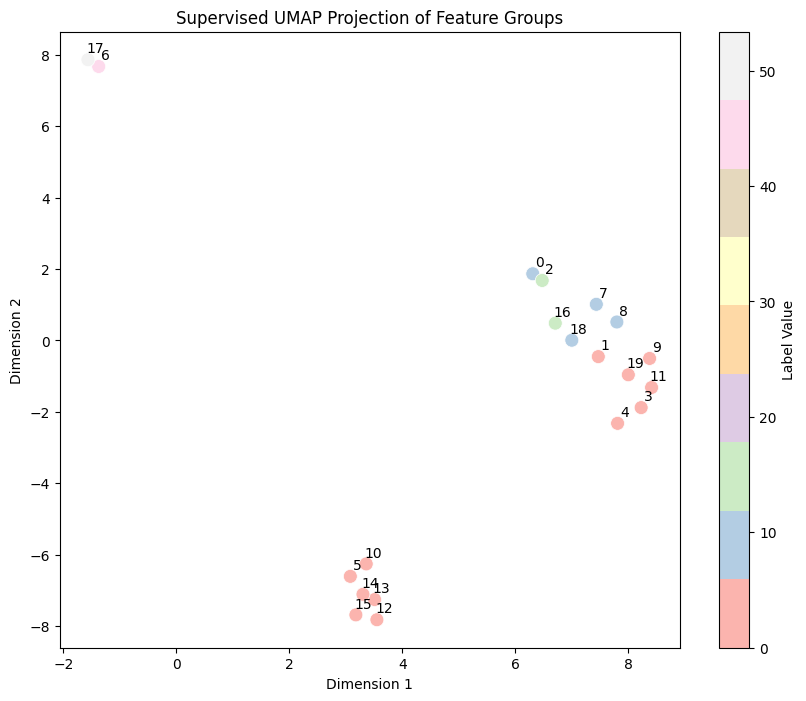

In [16]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding[:, 0], 
    embedding[:, 1], 
    c=exp_Y, 
    # cmap='viridis',
    cmap = 'Pastel1',
    s=100,
    edgecolor='w',
    linewidth=0.5
)
plt.colorbar(scatter, label='Label Value')
plt.title('Supervised UMAP Projection of Feature Groups')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
for i, txt in enumerate(range(len(exp_Y))):
    plt.annotate(txt, (embedding[i, 0], embedding[i, 1]), 
                 textcoords='offset points',
                 xytext=(5,5),
                 ha='center')
plt.savefig('small_data_2d')
plt.show()

# Adaptive PCA

In [17]:
def adaptive_pca(data, variance_threshold=0.95):
    """根据方差解释率自动选择主成分数量"""
    pca = PCA()
    pca.fit(data)
    cum_var = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(cum_var >= variance_threshold) + 1
    return PCA(n_components=n_components).fit_transform(data)

In [18]:
def compare_dim_reduction(X, y, n_components=2):
    """比较不同降维算法效果"""
    # UMAP
    umap_result = umap.UMAP(
        n_components=n_components,
        target_metric='euclidean',
        target_weight=0.9,
        n_neighbors=5,
        random_state=42
    ).fit_transform(X, y)
    
    # t-SNE
    tsne = TSNE(
        n_components=n_components,
        perplexity=3,  # 小数据集使用较小的perplexity
        early_exaggeration=12,
        learning_rate=200,
        random_state=42
    )
    tsne_result = tsne.fit_transform(X)
    
    # PHATE
    # phate_op = phate.PHATE(
    #     n_components=n_components,
    #     knn=3,  # 小数据集调整knn值
    #     random_state=42
    # )
    # phate_result = phate_op.fit_transform(X)
    
    return {
        'UMAP': umap_result,
        't-SNE': tsne_result,
        # 'PHATE': phate_result
    }

In [19]:
def plot_3d(embedding, y, title):
    """3D可视化函数"""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(
        embedding[:, 0], 
        embedding[:, 1],
        embedding[:, 2],
        c=exp_Y, 
        # cmap='viridis',
        cmap = 'Pastel1',
        s=100,
        edgecolor='w'
    )
    plt.colorbar(sc, label='Label Value')
    ax.set_title(title)
    
    # 标注数据点
    for i in range(len(y)):
        ax.text(embedding[i, 0], embedding[i, 1], embedding[i, 2], 
                str(i), color='black',
                fontsize=8, ha='center', va='center')

In [20]:
g1_pca = adaptive_pca(group1, 0.95)
g2_pca = adaptive_pca(group2, 0.95)
g3_pca = adaptive_pca(group3, 0.95)
g4_pca = adaptive_pca(group4, 0.01)

In [21]:
g4_pca.shape

(20, 1)

In [22]:
# X_pca = np.hstack([g1_pca,g4_pca])
X_pca = np.hstack([g2_pca,g4_pca])
# X_pca = np.hstack([g3_pca, g4_pca])

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

In [24]:
results_2d = compare_dim_reduction(X_scaled, exp_Y, 2)

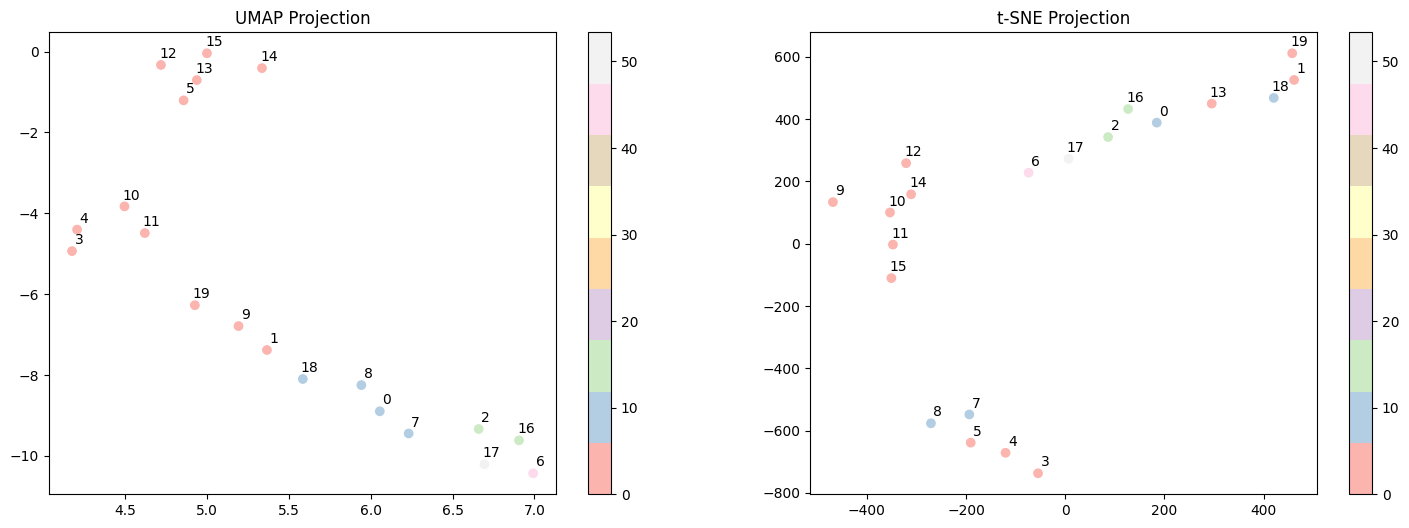

In [25]:
plt.figure(figsize=(18, 6))
for idx, (name, result) in enumerate(results_2d.items()):
    plt.subplot(1, 2, idx+1)
    scatter = plt.scatter(result[:, 0], result[:, 1], c=exp_Y, cmap='Pastel1')
    plt.colorbar(scatter)
    plt.title(f'{name} Projection')
    for i, txt in enumerate(range(len(exp_Y))):
        plt.annotate(txt, (result[i, 0], result[i, 1]),
                    textcoords='offset points',
                    xytext=(5,5),
                    ha='center')
    plt.savefig('small_data_cmp')

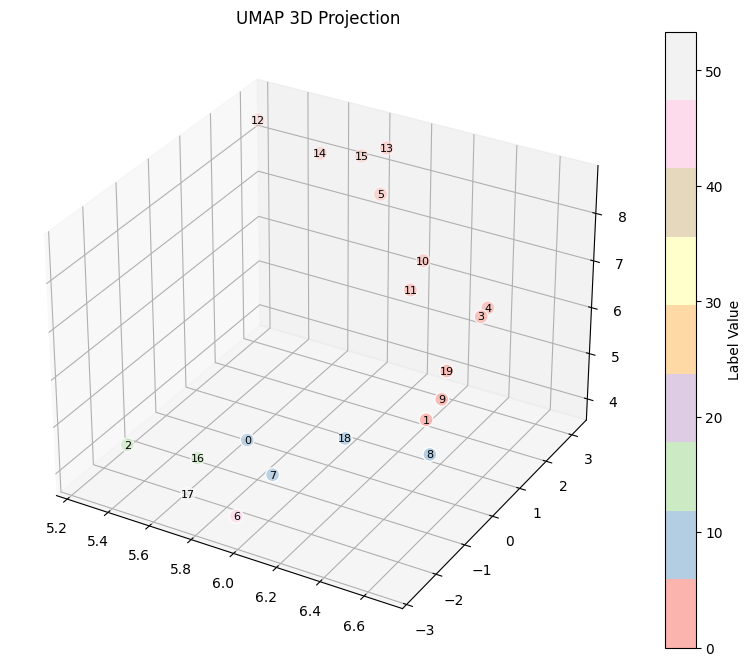

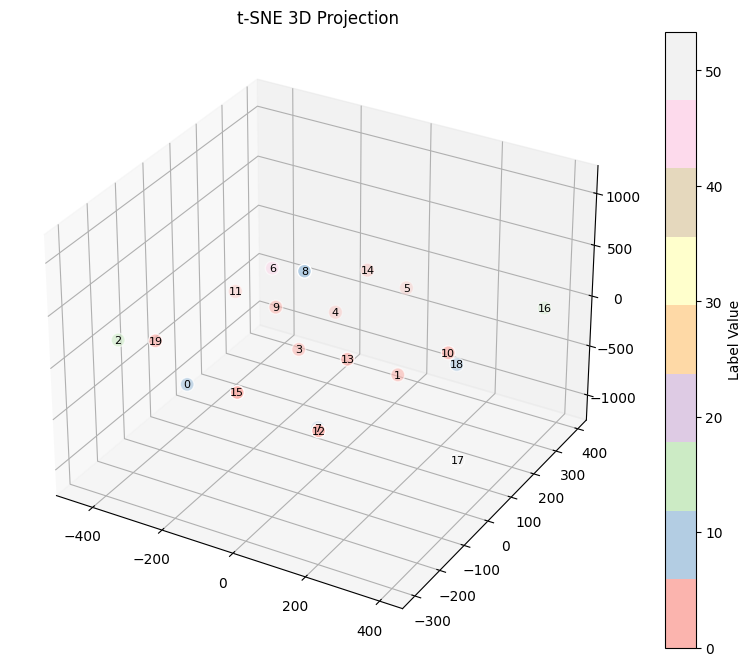

In [26]:
results_3d = compare_dim_reduction(X_scaled, exp_Y, 3)
for name, result in results_3d.items():
        plot_3d(result, exp_Y , f'{name} 3D Projection')
    
plt.show()

# Prediction Agent

# Load Data

In [27]:
exp_file = "Kraken monophosphine coordinates AD Descriptors.xlsx"
exp_sheet = "AD reduced"                                
expinput = pd.read_excel(exp_file,exp_sheet, header = 0)

In [28]:
exp_info_t = expinput.iloc[:,:4]
test_X = expinput.iloc[:,14:31].values
test_sterimo1 = expinput.iloc[:,14:17].values
test_sterimo2 = expinput.iloc[:,17:20].values
test_sterimo3 = expinput.iloc[:,20:23].values
test_set2 = expinput.iloc[:,23:31].values
test_res = expinput.iloc[:,31].values

In [29]:
test_X.shape

(237, 17)

In [30]:
g1 = test_sterimo1
g2 = test_sterimo2
g3 = test_sterimo3
g4 = test_set2
y = test_res
groups = {
    'g1': slice(0, 3),
    'g2': slice(3, 6),
    'g3': slice(6, 9),
    'g4': slice(9, 18)
}

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    test_X, test_res, test_size=0.2, random_state=42)

In [32]:
pca_models = {}
X_train_pca = []

In [33]:
for grp_name, grp_slice in groups.items():
    n_components = 4 if grp_name == 'g4' else 1  # 第四组保留4个成分
    pca = PCA(n_components=n_components)
    # 训练并转换训练集
    train_features = pca.fit_transform(X_train[:, grp_slice])
    X_train_pca.append(train_features)
    # 保存模型
    pca_models[grp_name] = pca

In [34]:
set1 = 0

In [35]:
# 合并训练集PCA特征
X_train_pca = np.hstack([X_train_pca[3],X_train_pca[set1]])

# ======== 标准化处理 ========
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)


In [36]:
# ======== 训练UMAP模型 ========
umap_model = umap.UMAP(
    n_components=2,
    target_metric='euclidean',
    target_weight=0.9,
    n_neighbors=5,
    random_state=42
)
X_train_umap = umap_model.fit_transform(X_train_scaled, y_train)

In [37]:
# ======== 测试集转换流程 ========
X_test_pca = []
for grp_name, grp_slice in groups.items():
    # 加载对应的PCA模型
    pca = pca_models[grp_name]
    
    # 转换测试集
    test_features = pca.transform(X_test[:, grp_slice])
    X_test_pca.append(test_features)

In [38]:
# 合并测试集PCA特征
X_test_pca = np.hstack([X_test_pca[3],X_test_pca[set1]])

# 应用相同的标准化
X_test_scaled = scaler.transform(X_test_pca)

# 应用UMAP转换
X_test_umap = umap_model.transform(X_test_scaled)

In [39]:
X_train_umap.shape
y_train.shape

(189,)

In [40]:
np.random.rand(189,).shape

(189,)

In [41]:
# ======== 训练预测模型 ========
# 使用随机森林回归（因label是连续值）
model = RandomForestRegressor(n_estimators=100, random_state=50)
model.fit(X_train_umap, y_train)
# model.fit(np.random.rand(189,2), y_train)

RandomForestRegressor(random_state=50)

In [42]:
# ======== 预测和评估 ========
y_pred = model.predict(X_test_umap)
mse = mean_squared_error(y_test, y_pred)
print(f"测试集MSE: {mse:.4f}")
print(f"预测示例:\n真实值: {y_test[:5]}\n预测值: {y_pred[:5].round(4)}")

测试集MSE: 0.0017
预测示例:
真实值: [0.28670751 0.16744651 0.21963728 0.22903686 0.25722106]
预测值: [0.1715 0.167  0.1856 0.2216 0.2503]


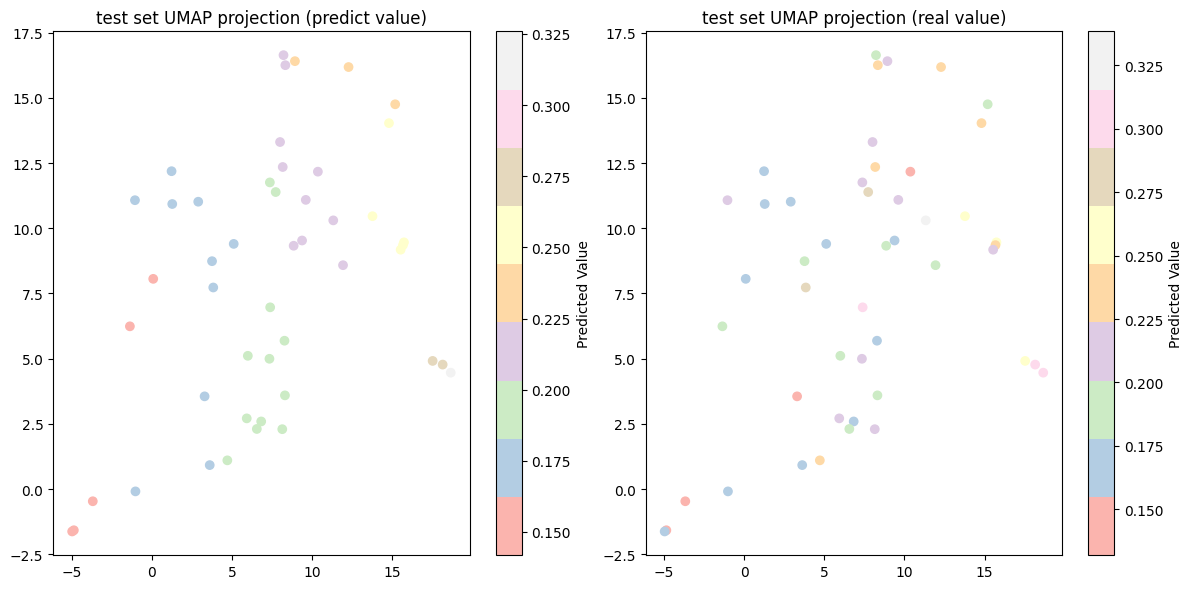

In [43]:
# ======== 可视化验证 ========
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 训练集可视化
# plt.subplot(2, 2, 1)
# # sc = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='viridis')
# sc = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='Pastel1')
# plt.colorbar(sc, label='Label Value')
# plt.title('train set UMAP projection')

# 测试集可视化（使用预测值着色）
plt.subplot(1, 2, 1)
sc = plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_pred, cmap='Pastel1')
plt.colorbar(sc, label='Predicted Value')
plt.title('test set UMAP projection (predict value)')

plt.tight_layout()
# plt.show()
# plt.figure(figsize=(12, 6))
# 测试集可视化（使用实际值着色）
plt.subplot(1, 2, 2)
sc = plt.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_test, cmap='Pastel1')
plt.colorbar(sc, label='Predicted Value')
plt.title('test set UMAP projection (real value)')

plt.tight_layout()
plt.savefig('predict_cmp')
plt.show()


In [44]:
np.sum(np.sort(np.abs(y_test - y_pred))>0.025)

17

In [45]:
thresh = 0.225

In [46]:
y_pred[y_pred>thresh]

array([0.25031377, 0.22727054, 0.26241528, 0.24602853, 0.28244938,
       0.32593379, 0.27870039, 0.2615924 , 0.26094997, 0.24377208])

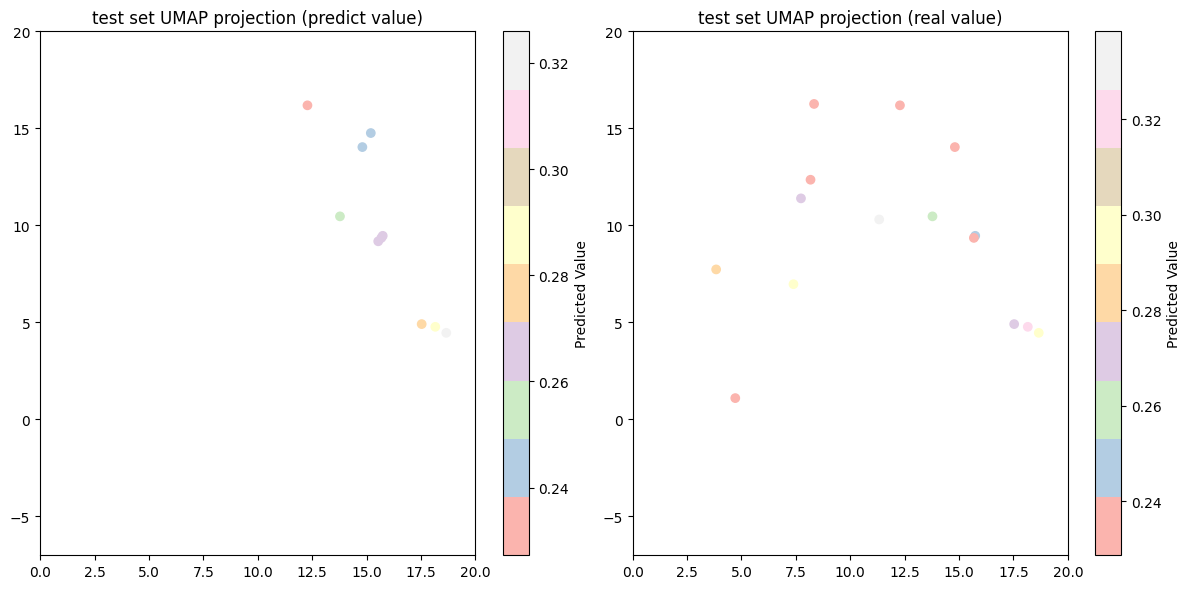

In [47]:
# ======== 可视化验证 ========
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 训练集可视化
# plt.subplot(2, 2, 1)
# # sc = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='viridis')
# sc = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='Pastel1')
# plt.colorbar(sc, label='Label Value')
# plt.title('train set UMAP projection')

# 测试集可视化（使用预测值着色）
plt.subplot(1, 2, 1)
sc = plt.scatter(X_test_umap[:, 0][y_pred>thresh], X_test_umap[:, 1][y_pred>thresh], c=y_pred[y_pred>thresh], cmap='Pastel1')
plt.xlim(0,20)
plt.ylim(-7,20)
plt.colorbar(sc, label='Predicted Value')
plt.title('test set UMAP projection (predict value)')

plt.tight_layout()
# plt.show()
# plt.figure(figsize=(12, 6))
# 测试集可视化（使用实际值着色）
plt.subplot(1, 2, 2)
sc = plt.scatter(X_test_umap[:, 0][y_test>thresh], X_test_umap[:, 1][y_test>thresh], c=y_test[y_test>thresh], cmap='Pastel1')
plt.xlim(0,20)
plt.ylim(-7,20)
plt.colorbar(sc, label='Predicted Value')
plt.title('test set UMAP projection (real value)')

plt.tight_layout()
plt.savefig('predict_ins')
plt.show()

In [48]:
np.where(y_pred>thresh)[0]

array([ 4,  9, 15, 17, 19, 23, 24, 31, 33, 44], dtype=int64)

In [49]:
np.where(y_test>thresh)[0]

array([ 0,  3,  4,  5,  9, 15, 16, 17, 19, 23, 24, 28, 31, 37, 38],
      dtype=int64)

In [50]:
15, 15, 9

(15, 15, 9)

# PLS regression

In [51]:
def optimize_pls(X, y):
    """通过交叉验证选择最佳主成分数"""
    mse_scores = []
    max_components = min(X.shape[1], 5)  # 最多尝试5个成分
    
    for n_comp in range(1, max_components+1):
        pls = PLSRegression(n_components=n_comp)
        # 简单交叉验证（适用于小数据集）
        scores = -cross_val_score(pls, X, y, cv=3,
                                scoring='neg_mean_squared_error')
        mse_scores.append(np.mean(scores))
    
    optimal_n = np.argmin(mse_scores) + 1
    print(f"最优主成分数: {optimal_n}")
    return optimal_n

In [52]:
optimal_components = optimize_pls(X_train_scaled, y_train)

最优主成分数: 3


In [53]:
pls = PLSRegression(n_components=optimal_components)
pls.fit(X_train_scaled, y_train)

PLSRegression(n_components=3)

In [54]:
y_train_pred = pls.predict(X_train_scaled)

# 测试集预测
y_test_pred = pls.predict(X_test_scaled)

In [55]:
def print_metrics(y_true, y_pred, set_name):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{set_name} MSE: {mse:.4f}")
    print(f"{set_name} R²: {r2:.4f}")

In [56]:
print_metrics(y_train, y_train_pred, "训练集")
print_metrics(y_test, y_test_pred, "测试集")

训练集 MSE: 0.0018
训练集 R²: 0.3844
测试集 MSE: 0.0014
测试集 R²: 0.4015


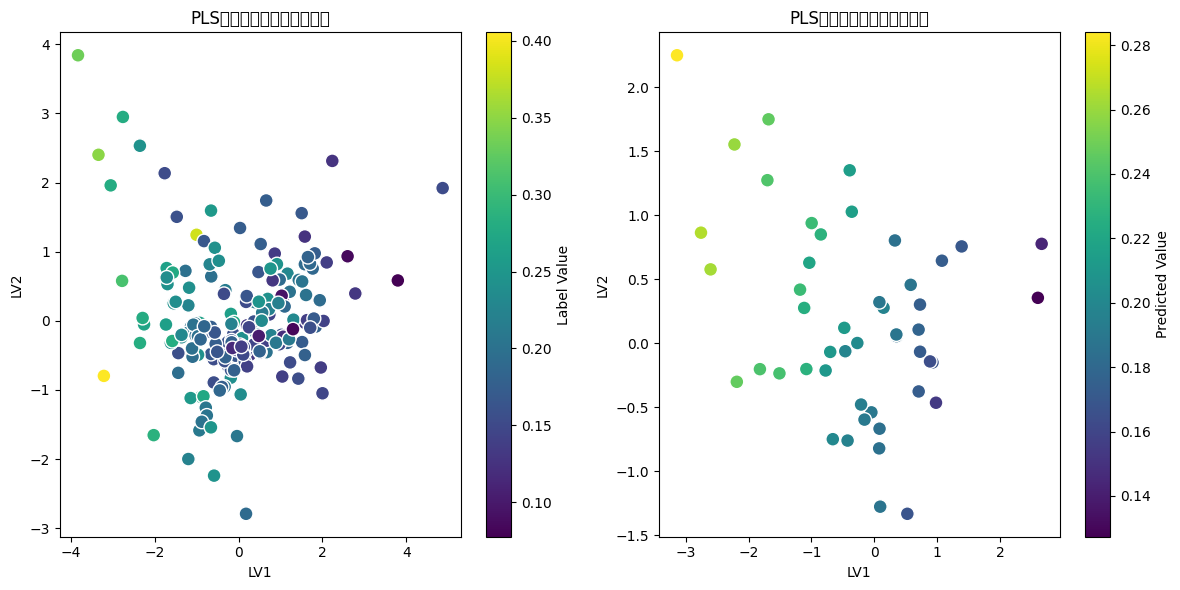

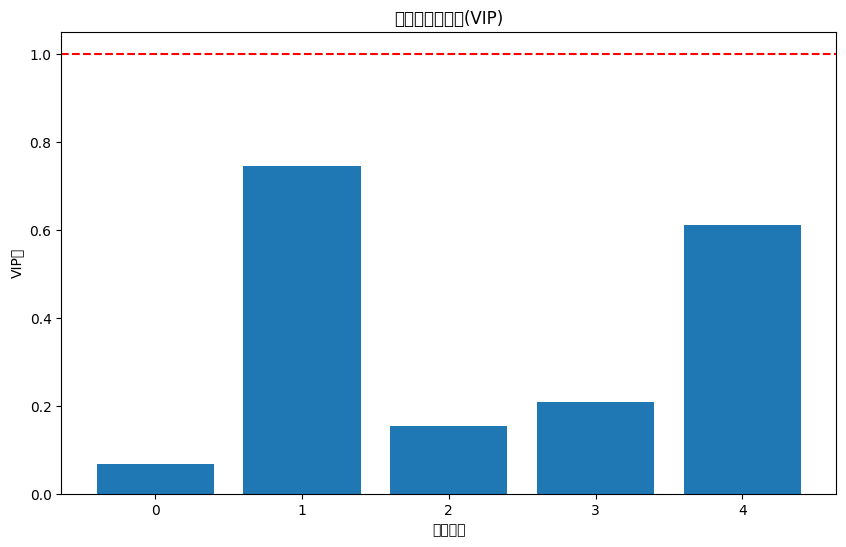

In [57]:
plt.figure(figsize=(12, 6))

# 潜在变量可视化（取前两个成分）
latent_vars = pls.transform(X_train_scaled)

# 训练集可视化
plt.subplot(1, 2, 1)
sc = plt.scatter(latent_vars[:, 0], latent_vars[:, 1], c=y_train, 
                cmap='viridis', s=100, edgecolor='w')
plt.colorbar(sc, label='Label Value')
plt.title('PLS潜在变量空间（训练集）')
plt.xlabel('LV1')
plt.ylabel('LV2')

# 测试集潜在变量
test_latent = pls.transform(X_test_scaled)

# 测试集可视化（使用预测值着色）
plt.subplot(1, 2, 2)
sc = plt.scatter(test_latent[:, 0], test_latent[:, 1], c=y_test_pred,
                cmap='viridis', s=100, edgecolor='w')
plt.colorbar(sc, label='Predicted Value')
plt.title('PLS潜在变量空间（测试集）')
plt.xlabel('LV1')
plt.ylabel('LV2')

plt.tight_layout()
plt.show()

# ======== 特征重要性分析 ========
# 计算变量投影重要性(VIP)
def calculate_vips(pls_model):
    t = pls_model.x_scores_  # 得分矩阵
    w = pls_model.x_weights_  # 权重矩阵
    q = pls_model.y_loadings_  # Y载荷
    
    s = np.diag(t.T @ t @ q.T @ q).reshape(-1, 1)
    vips = np.sqrt((w**2 @ s).sum(axis=1) / s.sum())
    return vips

vip_scores = calculate_vips(pls)
plt.figure(figsize=(10, 6))
plt.bar(range(len(vip_scores)), vip_scores)
plt.axhline(y=1, color='r', linestyle='--')
plt.title('变量投影重要性(VIP)')
plt.xlabel('特征索引')
plt.ylabel('VIP值')
plt.show()

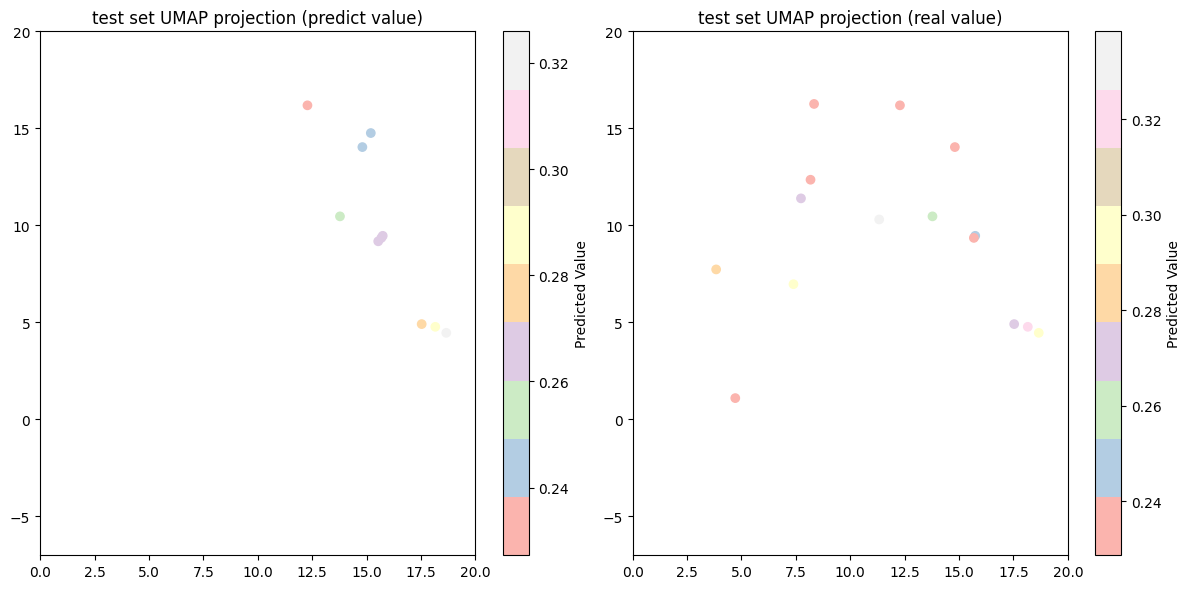

In [58]:
# ======== 可视化验证 ========
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 训练集可视化
# plt.subplot(2, 2, 1)
# # sc = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='viridis')
# sc = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='Pastel1')
# plt.colorbar(sc, label='Label Value')
# plt.title('train set UMAP projection')

# 测试集可视化（使用预测值着色）
plt.subplot(1, 2, 1)
sc = plt.scatter(X_test_umap[:, 0][y_pred>thresh], X_test_umap[:, 1][y_pred>thresh], c=y_pred[y_pred>thresh], cmap='Pastel1')
plt.xlim(0,20)
plt.ylim(-7,20)
plt.colorbar(sc, label='Predicted Value')
plt.title('test set UMAP projection (predict value)')

plt.tight_layout()
# plt.show()
# plt.figure(figsize=(12, 6))
# 测试集可视化（使用实际值着色）
plt.subplot(1, 2, 2)
sc = plt.scatter(X_test_umap[:, 0][y_test>thresh], X_test_umap[:, 1][y_test>thresh], c=y_test[y_test>thresh], cmap='Pastel1')
plt.xlim(0,20)
plt.ylim(-7,20)
plt.colorbar(sc, label='Predicted Value')
plt.title('test set UMAP projection (real value)')

plt.tight_layout()
# plt.savefig('predict_ins')
plt.show()


In [59]:
np.where(y_pred>thresh)[0]

array([ 4,  9, 15, 17, 19, 23, 24, 31, 33, 44], dtype=int64)

In [60]:
np.where(y_test>thresh)[0]

array([ 0,  3,  4,  5,  9, 15, 16, 17, 19, 23, 24, 28, 31, 37, 38],
      dtype=int64)

In [61]:
set(np.where(y_pred>thresh)[0])-set(np.where(y_test>thresh)[0])

{33, 44}

In [62]:
set(np.where(y_test>thresh)[0])-set(np.where(y_pred>thresh)[0])

{0, 3, 5, 16, 28, 37, 38}

# Phate

In [63]:
phate_operator = phate.PHATE(
    knn=4,                 # 减少邻接点数（适应小数据集）
    decay=20,              # 调整衰减参数
    n_components=2,        # 输出维度
    n_jobs=-1,             # 使用所有CPU核心
    random_state=42
)

In [64]:
# 训练集降维
phate_train = phate_operator.fit_transform(X_train_scaled)

# 测试集降维（使用训练好的PHATE模型）
phate_test = phate_operator.transform(X_test_scaled)

Calculating PHATE...
  Running PHATE on 189 observations and 5 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.04 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 0.05 seconds.
  Calculating optimal t...
    Automatically selected t = 33
  Calculated optimal t in 0.05 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.02 seconds.
Calculated PHATE in 0.11 seconds.
Calculating KNN search...
Calculated KNN search in 0.03 seconds.
Calculating affinities...


In [65]:
model = RandomForestRegressor(
    n_estimators=150,
    max_depth=3,
    random_state=42
)
model.fit(phate_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=150, random_state=42)

In [66]:
y_train_pred = model.predict(phate_train)
y_test_pred = model.predict(phate_test)

print(f"训练集MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"测试集MSE: {mean_squared_error(y_test, y_test_pred):.4f}")
print(f"训练集R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"测试集R²: {r2_score(y_test, y_test_pred):.4f}")

训练集MSE: 0.0016
测试集MSE: 0.0015
训练集R²: 0.4494
测试集R²: 0.3488


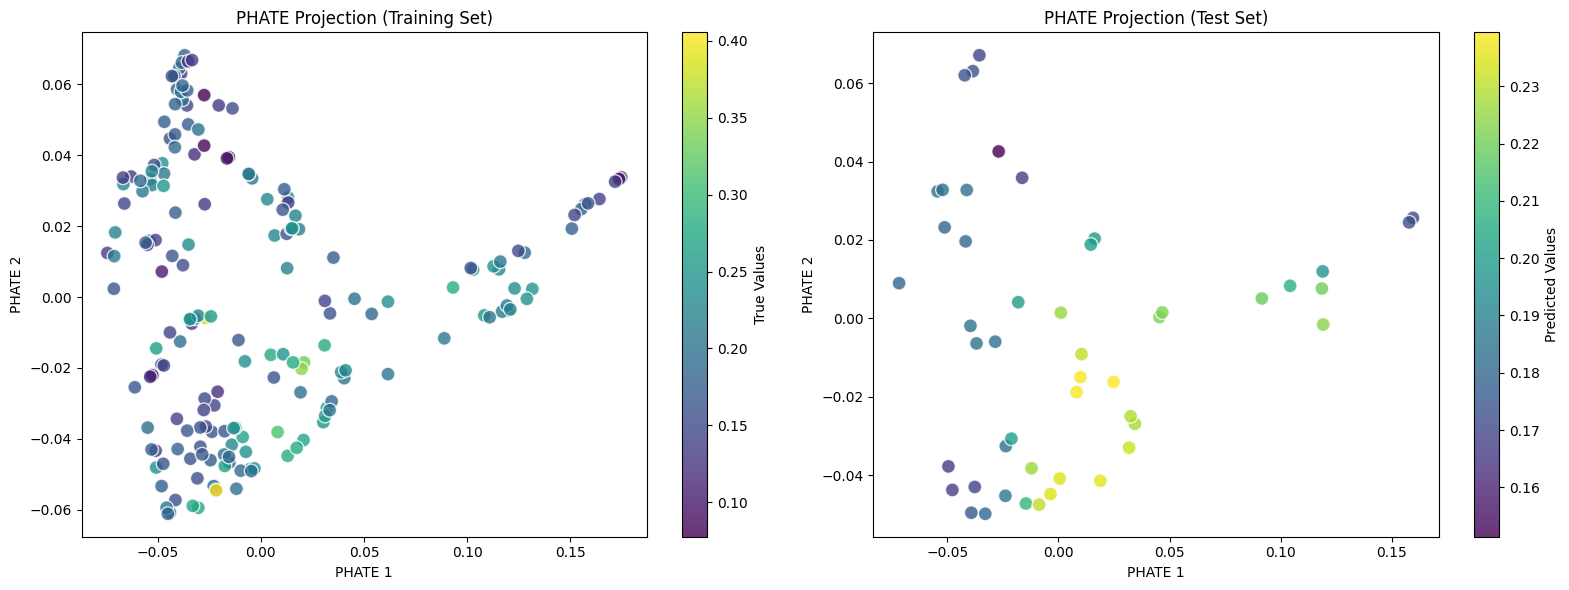

In [67]:
plt.figure(figsize=(16, 6))

# 训练集可视化
plt.subplot(1, 2, 1)
sc = plt.scatter(phate_train[:,0], phate_train[:,1], c=y_train,
                cmap='viridis', s=100, edgecolor='w', alpha=0.8)
plt.colorbar(sc, label='True Values')
plt.title('PHATE Projection (Training Set)')
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')

# 测试集可视化（使用预测值着色）
plt.subplot(1, 2, 2)
sc = plt.scatter(phate_test[:,0], phate_test[:,1], c=y_test_pred,
                cmap='viridis', s=100, edgecolor='w', alpha=0.8)
plt.colorbar(sc, label='Predicted Values')
plt.title('PHATE Projection (Test Set)')
plt.xlabel('PHATE 1')
plt.ylabel('PHATE 2')

plt.tight_layout()
plt.show()

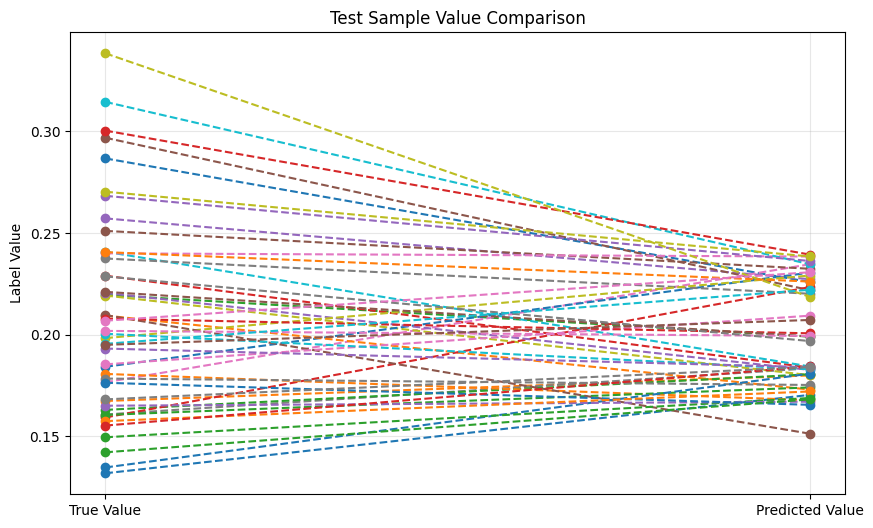

In [68]:
plt.figure(figsize=(10, 6))
for i, (true, pred) in enumerate(zip(y_test, y_test_pred)):
    plt.plot([1, 2], [true, pred], marker='o', linestyle='--')
plt.xticks([1, 2], ['True Value', 'Predicted Value'])
plt.ylabel('Label Value')
plt.title('Test Sample Value Comparison')
plt.grid(alpha=0.3)
plt.show()

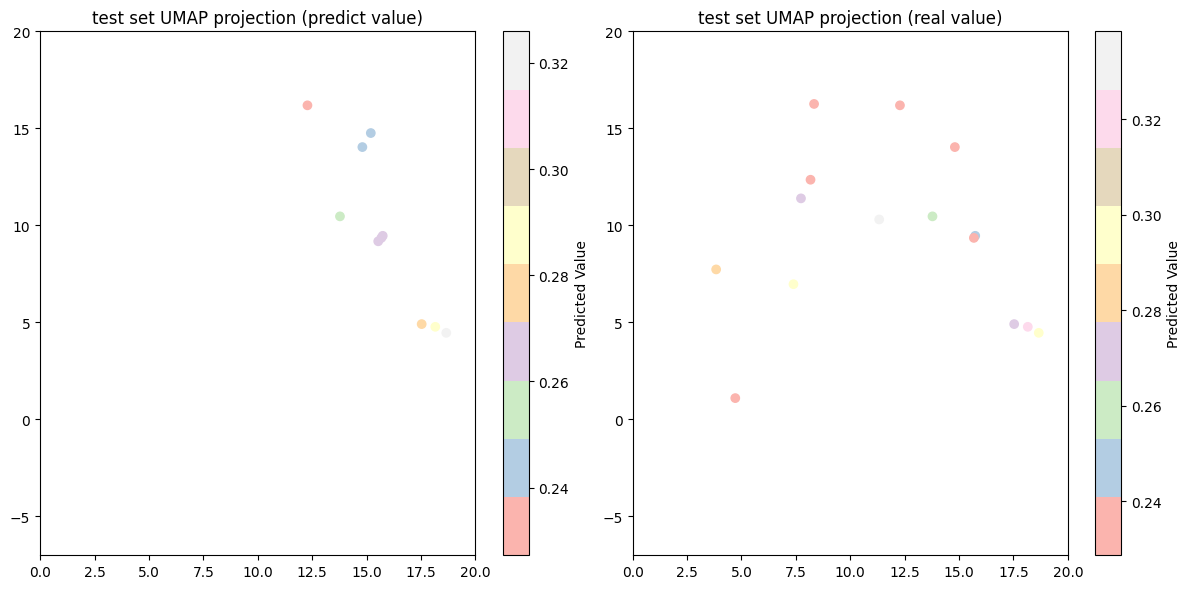

In [69]:
# ======== 可视化验证 ========
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 训练集可视化
# plt.subplot(2, 2, 1)
# # sc = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='viridis')
# sc = plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='Pastel1')
# plt.colorbar(sc, label='Label Value')
# plt.title('train set UMAP projection')

# 测试集可视化（使用预测值着色）
plt.subplot(1, 2, 1)
sc = plt.scatter(X_test_umap[:, 0][y_pred>thresh], X_test_umap[:, 1][y_pred>thresh], c=y_pred[y_pred>thresh], cmap='Pastel1')
plt.xlim(0,20)
plt.ylim(-7,20)
plt.colorbar(sc, label='Predicted Value')
plt.title('test set UMAP projection (predict value)')

plt.tight_layout()
# plt.show()
# plt.figure(figsize=(12, 6))
# 测试集可视化（使用实际值着色）
plt.subplot(1, 2, 2)
sc = plt.scatter(X_test_umap[:, 0][y_test>thresh], X_test_umap[:, 1][y_test>thresh], c=y_test[y_test>thresh], cmap='Pastel1')
plt.xlim(0,20)
plt.ylim(-7,20)
plt.colorbar(sc, label='Predicted Value')
plt.title('test set UMAP projection (real value)')

plt.tight_layout()
# plt.savefig('predict_ins')
plt.show()


In [70]:
np.where(y_pred>thresh)[0]

array([ 4,  9, 15, 17, 19, 23, 24, 31, 33, 44], dtype=int64)

In [71]:
np.where(y_test>thresh)[0]

array([ 0,  3,  4,  5,  9, 15, 16, 17, 19, 23, 24, 28, 31, 37, 38],
      dtype=int64)

In [72]:
set(np.where(y_pred>thresh)[0])-set(np.where(y_test>thresh)[0])

{33, 44}

In [73]:
set(np.where(y_test>thresh)[0])-set(np.where(y_pred>thresh)[0])

{0, 3, 5, 16, 28, 37, 38}